# Imports

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read raw data file

Data is not publicly available. Please contact the authors of the study for more information.

In [3]:
rawtable = pd.read_excel('All_HF_Frail_No_Frail_.xlsx')

Frailty (Zespol kruchosci) is our output. Inputs - only the TFI questions (except country).

Note that the ML models are not the final aim of the study, since the TFI scale is already used to rate frailty. We study feature importances (permutation importance) on 3 categories of these questions: physical, psychological and social.

# Data processing

## Conversion of variables for machine learning

Here we use one-hot encoding (https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) for variables of relationship variable, integer for age, simple binary form (0/1) for yes/no type and gender, and progressive increments (1, 2, ...) for ordered variables (education, salary, yes/sometimes/no).

In [4]:
rawtable.columns

Index(['Column1', 'Plec', 'Wiek [lata]', 'Wyksztalcenie', 'Stan cywilny',
       'Nadcisnienie tetnicze', 'Niewydolnosc serca', 'Cukrzyca', 'TFI3',
       'TFI6', 'TFI7', 'TFI8', 'TFI9.1', 'TFI9.2', 'TFI9.3', 'TFI9.4',
       'TFI9.5', 'TFI9.6', 'TFI10', 'TFI11', 'TFI12', 'TFI13', 'TFI14',
       'TFI15', 'TFI16', 'TFI17', 'TFI18', 'TFI19', 'TFI20', 'TFI21', 'TFI22',
       'TFI23', 'TFI24', 'TFI25', 'Skladniki fizyczne',
       'Skladniki psychologiczne', 'Skladniki spoleczne', 'Wynik ogolny TFI',
       'Zespol kruchosci'],
      dtype='object')

In [5]:
list_TFI_questions = [
    'Plec', 'Wiek [lata]', 'Wyksztalcenie', 'Stan cywilny',
    'TFI6', 'TFI7', 'TFI8', 'TFI9.1', 'TFI9.2', 'TFI9.3', 'TFI9.4',
    'TFI9.5', 'TFI9.6', 'TFI10', 'TFI11', 'TFI12', 'TFI13', 'TFI14',
    'TFI15', 'TFI16', 'TFI17', 'TFI18', 'TFI19', 'TFI20', 'TFI21', 'TFI22',
    'TFI23', 'TFI24', 'TFI25'
]

In [6]:
for q in list_TFI_questions:
    print(q+': '+str(rawtable[q].dropna().unique()))

Plec: [1 0]
Wiek [lata]: [81. 66. 79. 82. 67. 76. 77. 70. 85. 83. 84. 87. 74. 65. 61. 68. 78. 86.
 73. 69. 62. 80. 93. 88. 71. 72. 75. 90. 63. 64. 92. 60. 89. 56. 54. 35.
 53. 55. 40. 58. 57. 97. 59. 50. 49. 30. 91. 94.]
Wyksztalcenie: [2. 1. 3. 4.]
Stan cywilny: [1 0]
TFI6: [5. 2. 3. 6. 4. 1. 0.]
TFI7: ['Ani zdrowy ani niezdrowy' 'Zdrowy' 'Niezdrowy']
TFI8: [1. 0.]
TFI9.1: [0. 1.]
TFI9.2: [0. 1.]
TFI9.3: [0. 1.]
TFI9.4: [0. 1.]
TFI9.5: [0. 1.]
TFI9.6: [0. 1.]
TFI10: [1. 0.]
TFI11: [0 1]
TFI12: [0 1]
TFI13: [0 1]
TFI14: [0 1]
TFI15: [0 1]
TFI16: [1 0]
TFI17: [0 1]
TFI18: [0 1]
TFI19: [0 1]
TFI20: [0 1]
TFI21: [0 1]
TFI22: [1 0]
TFI23: [0 1]
TFI24: [1 0]
TFI25: [1 0]


In [7]:
ohe_questions = []

In [8]:
list_outputs = ['Zespol kruchosci']
tmp = rawtable[list_TFI_questions + list_outputs].dropna(axis=0, how='any')
tmp = tmp.reset_index()[list_TFI_questions + list_outputs]

In [9]:
def convert_to_ohe(q):
    t = tmp[q].dropna().unique()
    td = {}
    for i in t:
        td[q+'_'+i] = (tmp[q] == i).astype('int')
    return td

In [10]:
list_inputs = []
cleaned_data = {}
for q in list_TFI_questions:
    if q in ohe_questions:
        td = convert_to_ohe(q)
        for k in td.keys():
            list_inputs.append(k)
            cleaned_data[k] = td[k].copy()
    elif q == 'Wykształcenie':
        list_inputs.append(q)
        cleaned_data[q] = tmp[q].replace('Podstawowe',1).replace('Zawodowe',2).replace('Średnie',3).replace('Wyższe',4)
    elif q == 'TFI6':
        list_inputs.append(q)
        cleaned_data[q] = tmp[q].replace('0',0).replace('1',1).replace('2',2).replace('3',3).replace('4',4).replace('5',5).replace('6',6)
    elif q == 'TFI7':
        list_inputs.append(q)
        cleaned_data[q] = tmp[q].replace('Niezdrowy',0).replace('Ani zdrowy ani niezdrowy',0.5).replace('Zdrowy',1)
    elif q in ['TFI19','TFI20','TFI21','TFI24']:
        list_inputs.append(q)
        cleaned_data[q] = tmp[q].replace('Nie',0).replace('Czasami',0.5).replace('Tak',1)
    elif len(tmp[q].dropna().unique()) == 2:
        list_inputs.append(q)
        cleaned_data[q] = tmp[q].replace('Tak', 1).replace('Nie',0) # (tmp[q] == 'Tak').astype('int').copy()
    elif q == 'Płeć':
        list_inputs.append(q)
        cleaned_data[q] = (tmp[q] == 'Kobiety').astype('int').copy()
    else:
        list_inputs.append(q)
        cleaned_data[q] = tmp[q].copy()
cleaned_data[list_outputs[0]] = tmp[list_outputs[0]] #  = (tmp[list_outputs[0]] == 'Tak').astype('int').copy()
cleaned_data = pd.DataFrame(cleaned_data)
cleaned_data.shape

(612, 30)

In [11]:
cleaned_data.head()

,Plec,Wiek [lata],Wyksztalcenie,Stan cywilny,TFI6,TFI7,TFI8,TFI9.1,TFI9.2,TFI9.3,...,TFI17,TFI18,TFI19,TFI20,TFI21,TFI22,TFI23,TFI24,TFI25,Zespol kruchosci
0,1,81.0,2.0,1,5.0,0.5,1.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,1,1,0
1,1,66.0,1.0,0,2.0,0.5,1.0,0.0,0.0,0.0,...,1,1,1,0,1,1,1,1,1,1
2,0,79.0,2.0,0,3.0,0.5,1.0,0.0,0.0,0.0,...,1,1,1,0,1,1,0,1,0,1
3,0,82.0,3.0,0,6.0,1.0,1.0,0.0,0.0,0.0,...,1,1,1,0,0,0,1,1,0,1
4,1,67.0,1.0,0,5.0,1.0,1.0,0.0,1.0,0.0,...,0,1,0,0,0,1,1,1,1,0


# Splitting data for training, validation and testing

Seeded random splitting for reproduction of results. We will divide the data into 3 subsets (https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7) -- training, validation and testing sets, proportionally 4:1:1.

In [12]:
# Answer to the Ultimate Question of Life, The Universe, and Everything
my_seed = 42

In [133]:
from sklearn.model_selection import train_test_split

In [14]:
train_data, vt_data = train_test_split(cleaned_data, random_state=my_seed, train_size=4/6)

In [15]:
train_data.head()

,Plec,Wiek [lata],Wyksztalcenie,Stan cywilny,TFI6,TFI7,TFI8,TFI9.1,TFI9.2,TFI9.3,...,TFI17,TFI18,TFI19,TFI20,TFI21,TFI22,TFI23,TFI24,TFI25,Zespol kruchosci
415,0,86.0,1.0,1,2.0,0.5,1.0,0.0,1.0,1.0,...,1,1,1,0,0,0,0,0,1,1
284,1,73.0,3.0,0,4.0,0.0,1.0,0.0,1.0,0.0,...,1,1,1,1,0,1,1,1,1,1
538,0,65.0,3.0,1,6.0,1.0,1.0,1.0,0.0,0.0,...,1,1,0,1,1,1,0,1,1,1
208,1,70.0,4.0,1,6.0,1.0,0.0,0.0,0.0,0.0,...,1,0,1,1,1,1,0,1,1,1
261,1,65.0,3.0,1,6.0,0.5,1.0,0.0,0.0,0.0,...,1,1,0,1,1,1,0,1,1,1


In [16]:
val_data, test_data = train_test_split(vt_data, random_state=my_seed, train_size=1/2)

In [17]:
val_data.head()

,Plec,Wiek [lata],Wyksztalcenie,Stan cywilny,TFI6,TFI7,TFI8,TFI9.1,TFI9.2,TFI9.3,...,TFI17,TFI18,TFI19,TFI20,TFI21,TFI22,TFI23,TFI24,TFI25,Zespol kruchosci
77,0,81.0,2.0,0,5.0,0.5,1.0,0.0,1.0,0.0,...,1,1,0,1,0,1,0,0,1,1
135,1,82.0,1.0,0,4.0,0.5,0.0,0.0,0.0,0.0,...,1,1,1,0,0,1,0,1,1,1
302,1,65.0,4.0,1,1.0,1.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,1,0,1,1,0
22,1,70.0,3.0,1,3.0,0.5,1.0,0.0,1.0,1.0,...,1,1,0,0,0,1,0,1,1,1
92,1,87.0,4.0,0,6.0,0.5,0.0,0.0,1.0,0.0,...,0,0,0,1,1,1,1,1,1,1


In [18]:
test_data.head()

,Plec,Wiek [lata],Wyksztalcenie,Stan cywilny,TFI6,TFI7,TFI8,TFI9.1,TFI9.2,TFI9.3,...,TFI17,TFI18,TFI19,TFI20,TFI21,TFI22,TFI23,TFI24,TFI25,Zespol kruchosci
320,0,61.0,4.0,1,6.0,1.0,1.0,0.0,1.0,0.0,...,1,0,0,0,0,1,0,0,1,0
291,0,65.0,1.0,1,3.0,1.0,1.0,1.0,0.0,0.0,...,1,0,0,1,1,1,0,1,1,1
90,1,85.0,3.0,0,6.0,1.0,1.0,0.0,1.0,0.0,...,0,0,1,1,1,1,1,0,1,1
353,1,75.0,3.0,0,4.0,1.0,1.0,0.0,1.0,0.0,...,0,0,1,1,1,1,0,1,1,1
275,1,63.0,3.0,1,5.0,0.0,1.0,0.0,0.0,1.0,...,1,1,1,1,1,1,0,0,1,1


Text(0.5, 1.0, 'test')

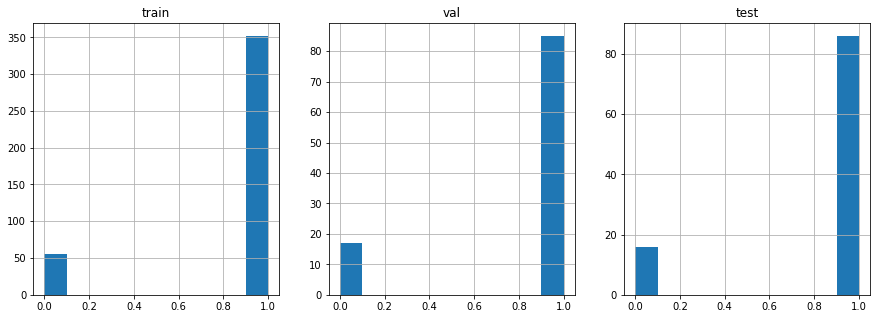

In [19]:
f, axes = plt.subplots(ncols=3, figsize=(15,5))
ax = axes[0]
train_data[list_outputs[0]].hist(ax=ax)
ax.set_title('train')
ax = axes[1]
val_data[list_outputs[0]].hist(ax=ax)
ax.set_title('val')
ax = axes[2]
test_data[list_outputs[0]].hist(ax=ax)
ax.set_title('test')

In [21]:
# Saving data to disk for ML models
train_data.to_csv(path_or_buf='train_r.csv')
val_data.to_csv(path_or_buf='val_r.csv')
test_data.to_csv(path_or_buf='test_r.csv')